# Alzheimer’s Disease Prediction by Machine Learning Models with MRI Images

### Importing Libraries

In [1]:
import opendatasets as od
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import cv2
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

### Loading The Dataset

Since the dataset consists of lots of MRI images, I decided to upload them by using Kaggle API.

In [2]:
dataset_url = "https://www.kaggle.com/datasets/sachinkumar413/alzheimer-mri-dataset"
od.download(dataset_url)

Skipping, found downloaded files in "./alzheimer-mri-dataset" (use force=True to force download)


### Dataset Analysis

In [3]:
#Dataset directory
dataset_dir = "./alzheimer-mri-dataset/Dataset"
print(os.listdir(dataset_dir))

files = os.listdir(dataset_dir)
print(f"Number of labels is {len(files)} in this dataset.")

['Moderate_Demented', 'Mild_Demented', 'Very_Mild_Demented', 'Non_Demented']
Number of labels is 4 in this dataset.


As we can see there are four groups of images in the dataset such as 'Moderate_Demented', 'Mild_Demented', 'Very_Mild_Demented' and 'Non_Demented'.

In [4]:
total_images = 0
label_counts = {}
for label in os.listdir(dataset_dir):
    label_dir = os.path.join(dataset_dir, label)
    if os.path.isdir(label_dir):
        num_images = len(os.listdir(label_dir))
        total_images += num_images
        label_counts[label] = num_images
        print(f"Number of images in {label} folder: {num_images}")

print(f"Total number of images in the dataset: {total_images}")

Number of images in Moderate_Demented folder: 64
Number of images in Mild_Demented folder: 896
Number of images in Very_Mild_Demented folder: 2240
Number of images in Non_Demented folder: 3200
Total number of images in the dataset: 6400


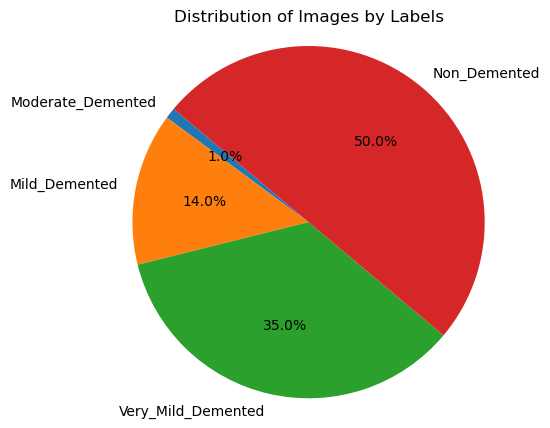

In [5]:
plt.figure(figsize=(5, 5))
plt.pie(label_counts.values(), labels=label_counts.keys(), autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Images by Labels')
plt.axis('equal')
plt.show()

In [6]:
def visualise_images(path, label, num_samples= 5):
    label_dir = os.path.join(path, label)
    image_files = os.listdir(label_dir)
    random_samples = random.sample(image_files, min(num_samples, len(image_files)))
    
    plt.figure(figsize=(20, 4))
    for i, image_file in enumerate(random_samples):
        img_path = os.path.join(label_dir, image_file)
        img = mpimg.imread(img_path)
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f'{label} Image {i+1}')
        plt.axis('off')
    plt.show()

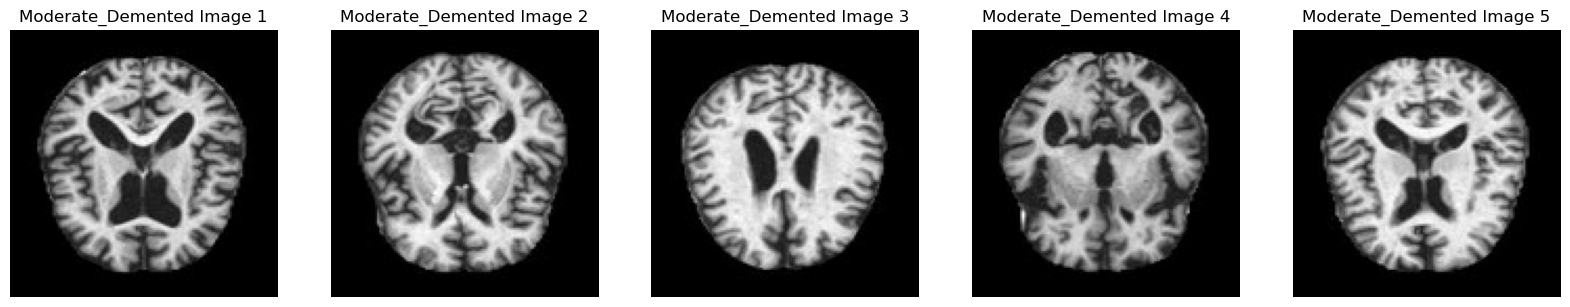

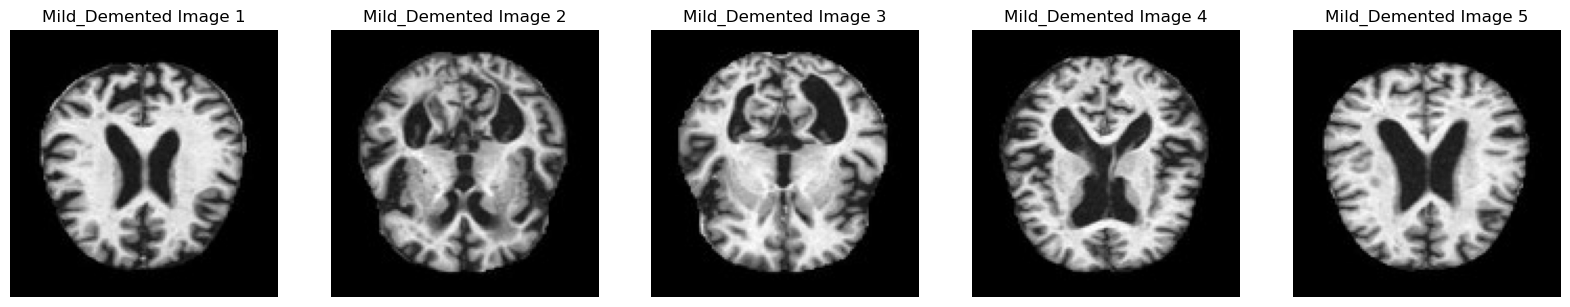

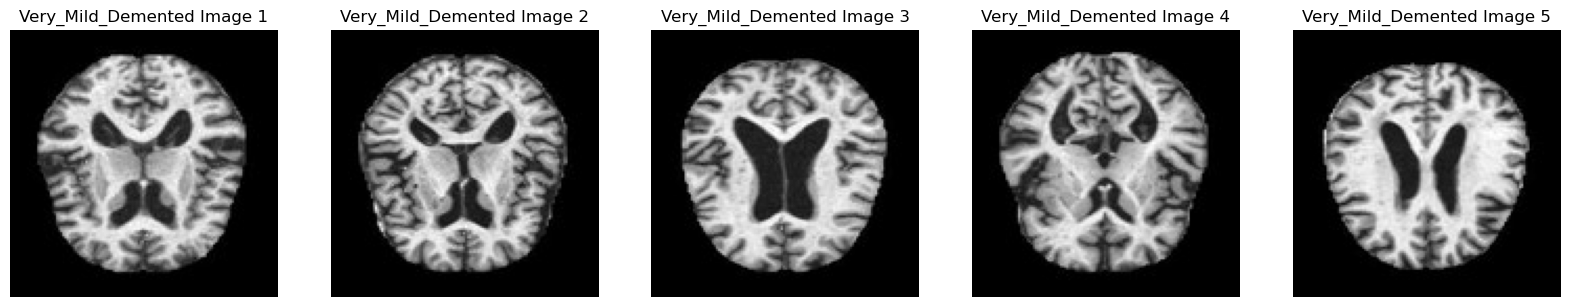

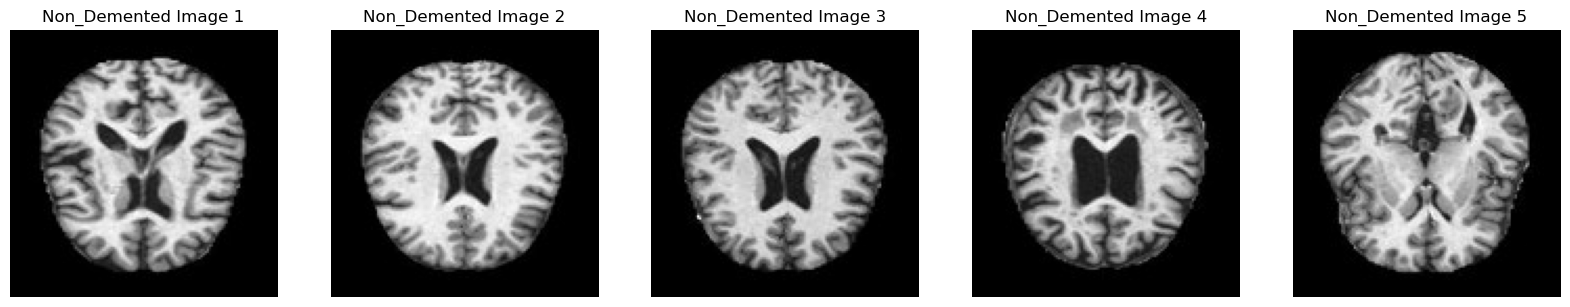

In [7]:
labels = os.listdir(dataset_dir)
for label in labels:
    visualise_images(dataset_dir, label)

### Dataset Preprocessing

#### Resize

Each image in the dataset needs to have the same size—that is, 128 × 128. Even though the images that were chosen randomly have the same size, it is still important to review the data set and make any modifications that are required.

In [8]:
def resize_images(path, label, size=(128,128)):
    label_dir = os.path.join(path, label)
    for image_file in os.listdir(label_dir):
        img_path = os.path.join(label_dir, image_file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img.shape != size:
            img_resized = cv2.resize(img, size)
            cv2.imwrite(img_path, img_resized) 

In [9]:
labels = os.listdir(dataset_dir)
for label in labels:
    resize_images(dataset_dir, label)
    if resize_images(dataset_dir, label):
        print(f"Images resized in {label}.")
    else:
        print(f"None of the images needed to be resized in {label}.")

None of the images needed to be resized in Moderate_Demented.
None of the images needed to be resized in Mild_Demented.
None of the images needed to be resized in Very_Mild_Demented.
None of the images needed to be resized in Non_Demented.


### Data Augmentation

There is a significant imbalance in the data set, as we have already analysed.  A greater number of images have been included in some labels than others. It has been decided to use the Generative Model to perform augmentation to prevent any potential problems that this situation might cause. 

#### DCGAN

In [10]:
#parameters
img_size=(128, 128)
batch_size=32

In [11]:
img_data = keras. utils.image_dataset_from_directory(
    directory='./alzheimer-mri-dataset/Dataset',
    batch_size = batch_size,
    image_size = img_size)

dataset_dir = "./alzheimer-mri-dataset/Dataset"
img_generator = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip = True)

img_data = img_generator.flow_from_directory(
        dataset_dir,
        target_size = img_size,
        batch_size = batch_size,
        classes=["Moderate_Demented"])

Found 6400 files belonging to 4 classes.
Found 64 images belonging to 1 classes.


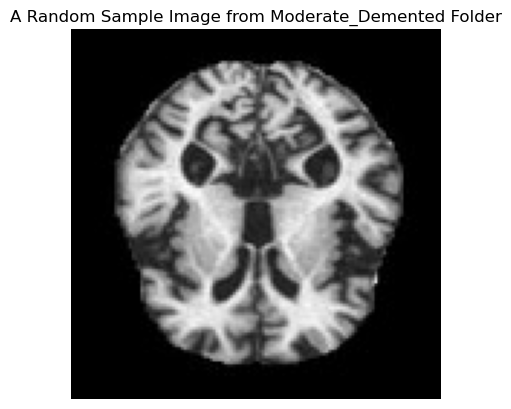

In [12]:
for batch in img_data:
    random_index = random.randint(0, len(batch[0]) - 1)
    plt.axis("off")
    plt.imshow(batch[0][random_index])
    plt.title("A Random Sample Image from Moderate_Demented Folder")
    plt.show()
    break

In [27]:
#Generator
latent_dim = 128
def generator_model():
    generator = tf.keras.Sequential([
        layers.Dense(8 * 8 * 256, input_dim=latent_dim),
        layers.Reshape((8, 8, 256)),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')
    ])
    return generator

generator = generator_model()
generator.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 16384)             2113536   
                                                                 
 reshape_5 (Reshape)         (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose_13 (Conv2D  (None, 16, 16, 128)      524416    
 Transpose)                                                      
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_14 (Conv2D  (None, 32, 32, 128)      262272    
 Transpose)                                                      
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 32, 32, 128)      

In [37]:
#Discriminator
def discriminator_model(img_size):
    discriminator = tf.keras.Sequential([
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=(img_size[0], img_size[1], 3)),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.4),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.4),
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')
    ])
    return discriminator

discriminator = discriminator_model(img_size)
discriminator.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 64, 64, 64)        1792      
                                                                 
 leaky_re_lu_27 (LeakyReLU)  (None, 64, 64, 64)        0         
                                                                 
 dropout_12 (Dropout)        (None, 64, 64, 64)        0         
                                                                 
 conv2d_18 (Conv2D)          (None, 32, 32, 128)       73856     
                                                                 
 leaky_re_lu_28 (LeakyReLU)  (None, 32, 32, 128)       0         
                                                                 
 dropout_13 (Dropout)        (None, 32, 32, 128)       0         
                                                                 
 flatten_6 (Flatten)         (None, 131072)          